<a href="https://colab.research.google.com/github/reza-pishva/1-SchoolProject-Php-Laravel/blob/main/rnn_comp_brg_vib_ansaldo_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install darts

In [64]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from darts import TimeSeries
from darts.models import RNNModel,NBEATSModel,TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from darts.metrics import mae as darts_mae
import warnings # Ignore specific warnings
warnings.filterwarnings("ignore")


In [65]:
df1 = pd.read_csv('dsas2132_comp_vib.csv')

In [66]:
filtered_df = df1[(df1['Job'] == 'Operation') & (df1['IsDeleted'] == 0) & (df1['ValueType'] == 1) & (df1['AssetID'].isin([12221 ,12222 ,12223 ,12224]))]
df2 = filtered_df.drop(columns=['PersonelID', 'MobileID', 'Job', 'IsDeleted','OutofRange','ValueType','UnitID','OnTime'])
df2.head()

,ID,AssetID,Value,RecordTime,RecordDate,DateTime,TimeStamp,ShiftCode
24,1055642,12221,24.0,09:39:03,2021/03/19,2021-03-19 09:39:03.000,1616134143,12
25,1055643,12222,1.7,09:39:07,2021/03/19,2021-03-19 09:39:07.000,1616134147,12
26,1055644,12223,47.0,09:39:11,2021/03/19,2021-03-19 09:39:11.000,1616134151,12
27,1055645,12224,1.0,09:39:14,2021/03/19,2021-03-19 09:39:14.000,1616134154,12
40,1057188,12221,36.7,20:47:03,2021/03/20,2021-03-20 20:47:03.000,1616260623,12


In [67]:
number_of_rows = df1.shape[0]
print("Number of rows:", number_of_rows)

Number of rows: 118204


In [68]:
def plot_and_display(asset_id , date1 , date2):
    # Filter the DataFrame for the given AssetID
    filtered_df = df1[df1['AssetID'] == asset_id]

    # Combine RecordDate and RecordTime into a single datetime column
    filtered_df['DateTime'] = pd.to_datetime(filtered_df['RecordDate'] + ' ' + filtered_df['RecordTime'])

    # Sort the DataFrame by DateTime
    filtered_df = filtered_df.sort_values(by='DateTime')

    # Filter the DataFrame for the first month of 2022
    filtered_df = filtered_df[(filtered_df['DateTime'] >= date1) & (filtered_df['DateTime'] <= date2)]

    filtered_df['Value'].hist()

    # Display the DataFrame as HTML
    display(HTML(filtered_df[['ShiftCode','RecordDate','RecordTime','Value']].to_html(max_rows=None)))

    # Plot the data
    plt.figure(figsize=(6,4))
    plt.plot(filtered_df['DateTime'], filtered_df['Value'], marker='o', linestyle='-')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title(f'Value vs. DateTime for January 2022 - AssetID {asset_id}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

,ShiftCode,RecordDate,RecordTime,Value
34311,20211231191459,2022/01/01,02:05:37,46.00
34247,20211231191459,2022/01/01,02:10:06,22.00
34315,20211231191459,2022/01/01,02:14:41,13.52
34251,20211231191459,2022/01/01,02:15:44,26.00
34255,20211231191459,2022/01/01,05:07:01,26.80
34259,20211231191459,2022/01/01,05:12:16,21.00
34319,20211231191459,2022/01/01,05:13:53,47.00
34323,20211231191459,2022/01/01,05:25:31,14.00
34327,20220101080202,2022/01/01,08:08:15,44.00
34331,20220101080202,2022/01/01,08:12:05,14.00


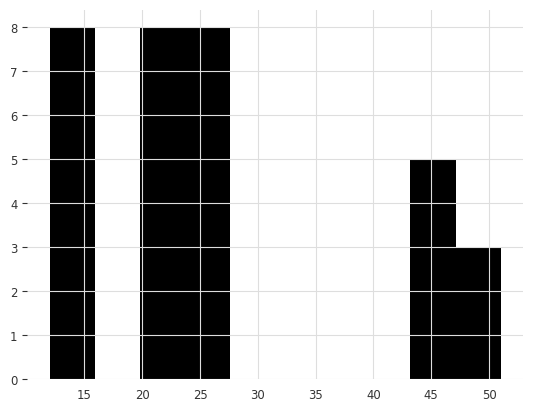

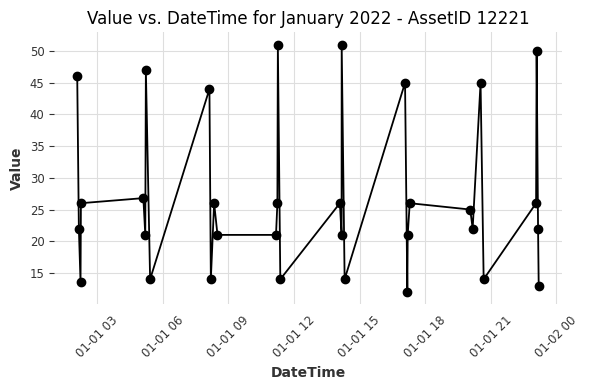

In [69]:
plot_and_display(12221 ,'2022-01-01','2022-01-02')

In [70]:
# AssetIDs to check
asset_ids_to_check = [12221 ,12222 ,12223 ,12224]

# Filter the DataFrame to include only the specified AssetIDs
filtered_df = df1[df1['AssetID'].isin(asset_ids_to_check)]

# Initialize a list to keep track of valid ShiftCodes
valid_shiftcodes = []

# Iterate through each ShiftCode and check the count of each AssetID
for shift_code in filtered_df['ShiftCode'].unique():
    shift_code_df = filtered_df[filtered_df['ShiftCode'] == shift_code]
    asset_count = shift_code_df['AssetID'].value_counts()

    if all(asset_count == 16):
        valid_shiftcodes.append(shift_code)

# Filter the original DataFrame to keep only the rows with valid ShiftCodes
df2 = df1[df1['ShiftCode'].isin(valid_shiftcodes)]

In [71]:
date1='2022-01-01'
date2='2024-01-01'
filtered_df1 = df2[df2['AssetID']==12221]
filtered_df2 = df2[df2['AssetID']==12222]
filtered_df3 = df2[df2['AssetID']==12223]
filtered_df4 = df2[df2['AssetID']==12224]
# Combine RecordDate and RecordTime into a single datetime column
filtered_df1['DateTime'] = pd.to_datetime(filtered_df1['RecordDate'] + ' ' + filtered_df1['RecordTime'])
filtered_df2['DateTime'] = pd.to_datetime(filtered_df2['RecordDate'] + ' ' + filtered_df2['RecordTime'])
filtered_df3['DateTime'] = pd.to_datetime(filtered_df3['RecordDate'] + ' ' + filtered_df3['RecordTime'])
filtered_df4['DateTime'] = pd.to_datetime(filtered_df4['RecordDate'] + ' ' + filtered_df4['RecordTime'])
# Sort the DataFrame by DateTime
filtered_df1 = filtered_df1.sort_values(by='DateTime')
filtered_df2 = filtered_df2.sort_values(by='DateTime')
filtered_df3 = filtered_df3.sort_values(by='DateTime')
filtered_df4 = filtered_df4.sort_values(by='DateTime')
# Filter the DataFrame for the first month of 2022
lube_oil_df1 = filtered_df1[(filtered_df1['DateTime'] >= date1) & (filtered_df1['DateTime'] <= date2)]
lube_oil_df2 = filtered_df2[(filtered_df2['DateTime'] >= date1) & (filtered_df2['DateTime'] <= date2)]
lube_oil_df3 = filtered_df3[(filtered_df3['DateTime'] >= date1) & (filtered_df3['DateTime'] <= date2)]
lube_oil_df4 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]
lube_oil_df5 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]
lube_oil_df6 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]
lube_oil_df7 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]
lube_oil_df8 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]

lube_oil_df1.dropna(subset=['Value'])
lube_oil_df2.dropna(subset=['Value'])
lube_oil_df3.dropna(subset=['Value'])
lube_oil_df4.dropna(subset=['Value'])


# Ensure both DataFrames are properly indexed
df1 = lube_oil_df1.reset_index(drop=True)
df2 = lube_oil_df2.reset_index(drop=True)
df3 = lube_oil_df3.reset_index(drop=True)
df4 = lube_oil_df4.reset_index(drop=True)
df5 = lube_oil_df4.reset_index(drop=True)
df6 = lube_oil_df4.reset_index(drop=True)
df7 = lube_oil_df4.reset_index(drop=True)
df8 = lube_oil_df4.reset_index(drop=True)

df5['Value1']=df1['Value']
df6['Value2']=df2['Value']
df7['Value3']=df3['Value']
df8['Value4']=df4['Value']

# Create a new DataFrame by concatenating the 'Value' columns from each DataFrame
df = pd.concat([df1['ShiftCode'],df1['TimeStamp'],df1['DateTime'],df1['AssetID'], df5['Value1'], df6['Value2'], df7['Value3'], df8['Value4']], axis=1)


In [72]:
df.head()

,ShiftCode,TimeStamp,DateTime,AssetID,Value1,Value2,Value3,Value4
0,20211231191459,1640990137,2022-01-01 02:05:37,12221,46.00,2.75,28.59,2.67
1,20211231191459,1640990406,2022-01-01 02:10:06,12221,22.00,1.50,53.00,1.50
2,20211231191459,1640990681,2022-01-01 02:14:41,12221,13.52,1.60,23.64,2.74
3,20211231191459,1640990744,2022-01-01 02:15:44,12221,26.00,1.30,28.00,2.20
4,20211231191459,1641001021,2022-01-01 05:07:01,12221,26.80,1.30,28.00,2.18


In [73]:
# Convert 'timestamp' to datetime
df['DateTime'] = pd.to_datetime(df['TimeStamp'], unit='s')

In [51]:
# Ensure the 'Value' column is numeric, converting if necessary
# df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [74]:
# Filter the DataFrame based on your conditions
filtered_df = df[(df['AssetID'].isin([12223]))]
df.head()

,ShiftCode,TimeStamp,DateTime,AssetID,Value1,Value2,Value3,Value4
0,20211231191459,1640990137,2021-12-31 22:35:37,12221,46.00,2.75,28.59,2.67
1,20211231191459,1640990406,2021-12-31 22:40:06,12221,22.00,1.50,53.00,1.50
2,20211231191459,1640990681,2021-12-31 22:44:41,12221,13.52,1.60,23.64,2.74
3,20211231191459,1640990744,2021-12-31 22:45:44,12221,26.00,1.30,28.00,2.20
4,20211231191459,1641001021,2022-01-01 01:37:01,12221,26.80,1.30,28.00,2.18


In [105]:
# Filter the data to include only the specific date range
filtered_df = df[(df['DateTime'] >= '2023-01-20') & (df['DateTime'] <= '2023-02-01')]

In [106]:
if not filtered_df.index.inferred_type == 'datetime64':
    filtered_df['DateTime'] = pd.to_datetime(filtered_df['DateTime'])
    filtered_df = filtered_df.set_index('DateTime')

In [107]:
# Check for duplicates in the 'DateTime' index
duplicates = filtered_df.index[filtered_df.index.duplicated()]
print("Duplicate DateTime entries (before removal):", duplicates)

Duplicate DateTime entries (before removal): DatetimeIndex([], dtype='datetime64[ns]', name='DateTime', freq=None)


In [108]:
# Drop duplicates
filtered_df = filtered_df[~filtered_df.index.duplicated(keep='first')]

In [110]:
# Forward fill to handle any NaN values resulted from resampling
filtered_df = filtered_df.ffill()

In [111]:
# Creating the TimeSeries object
series = TimeSeries.from_dataframe(filtered_df, value_cols='Value1', freq='S')

In [112]:
# Fill missing values
filled_series = fill_missing_values(series, "auto", fill_missing_dates=True)

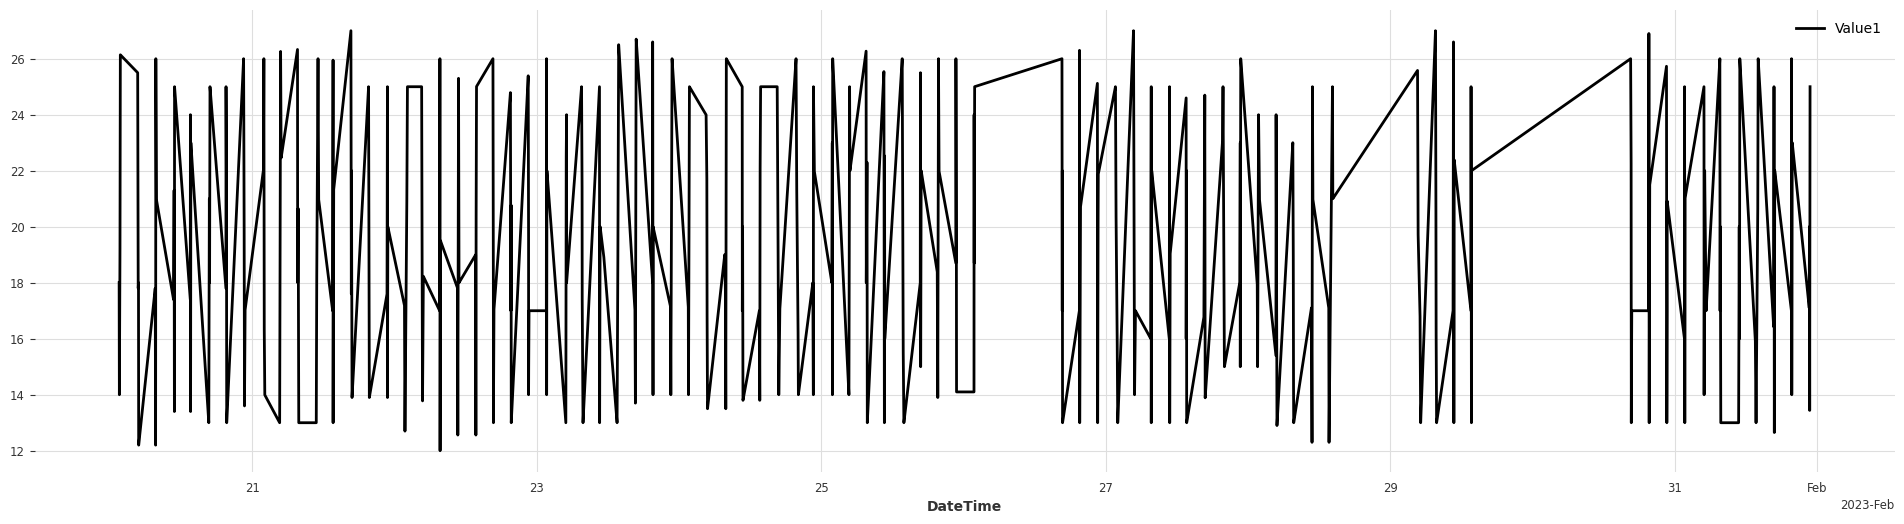

In [113]:
# Set figure size for wider plot
plt.figure(figsize=(24, 6)) # Width is set to 16, height is set to 6
# Plot the time series values
filled_series.plot()
plt.show() # Display the plot

In [114]:
# Initialize the Darts scaler
scaler = Scaler()
# Fit and transform the data
scaled_data = scaler.fit_transform(filled_series)

In [115]:
# Split the dataset into training and test sets
train_ts, val_ts = scaled_data.split_after(0.8)

In [116]:
nbeats_model = NBEATSModel(
            num_stacks = 5,
            num_layers = 4,
            input_chunk_length=30,
            output_chunk_length=5,
            generic_architecture=True,
            layer_widths=512,
            n_epochs=1,
            random_state=42,
            activation='LeakyReLU')


In [117]:
nbeats_model.fit(train_ts)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.0 M  | train
-------------------------------------------------------------
4.0 M     Trainable params
2.7 K     Non-trainable params
4.0 M     Total params
16.184    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=5, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=LeakyReLU, input_chunk_length=30, output_chunk_length=5, n_epochs=1, random_state=42)

In [118]:
prediction = nbeats_model.predict(20)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [119]:
# Inverse transform the predictions
inverted_prediction1 = scaler.inverse_transform(prediction)
inverted_prediction2 = scaler.inverse_transform(val_ts)

<Axes: xlabel='DateTime'>

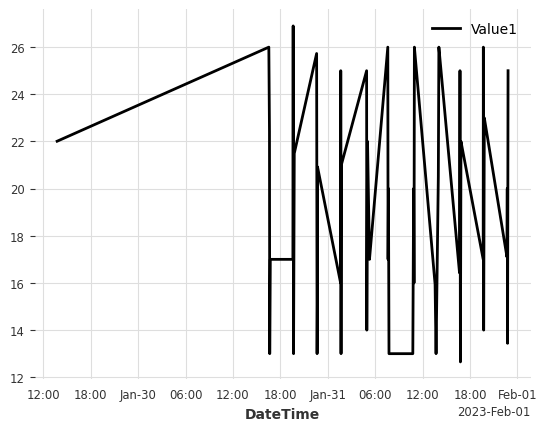

In [120]:
inverted_prediction2.plot()

<Axes: xlabel='DateTime'>

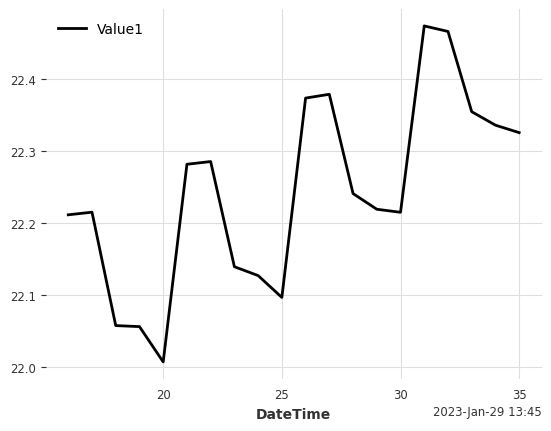

In [121]:
inverted_prediction1.plot()

In [122]:
mae = darts_mae(inverted_prediction1,inverted_prediction2)
mae

0.2327128860498034

In [123]:
# Initialize the RNN model
rnn_model = RNNModel(model="LSTM",
                     hidden_dim=50,
                     n_rnn_layers=4,
                     n_epochs=1,
                     input_chunk_length=10,
                     output_chunk_length=1)


# Fit the model on the training data


In [124]:
rnn_model.fit(train_ts)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 71.8 K | train
6 | V               | Linear           | 51     | train
-------------------------------------------------------------
71.9 K    Trainable params
0         Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


RNNModel(model=LSTM, hidden_dim=50, n_rnn_layers=4, dropout=0.0, training_length=24, n_epochs=1, input_chunk_length=10, output_chunk_length=1)

In [125]:
prediction = rnn_model.predict(20)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [126]:
# Inverse transform the predictions
inverted_prediction1 = scaler.inverse_transform(prediction)
inverted_prediction2 = scaler.inverse_transform(val_ts)

<Axes: xlabel='DateTime'>

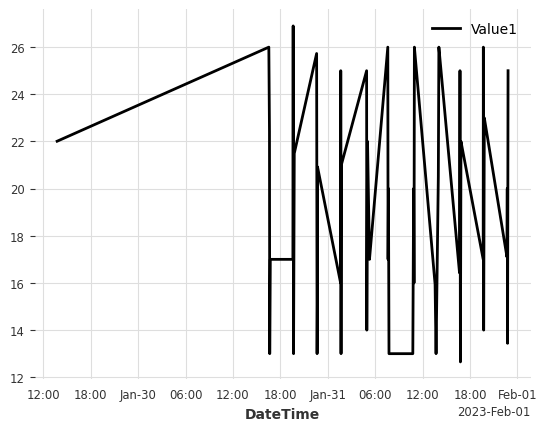

In [127]:
inverted_prediction2.plot()

<Axes: xlabel='DateTime'>

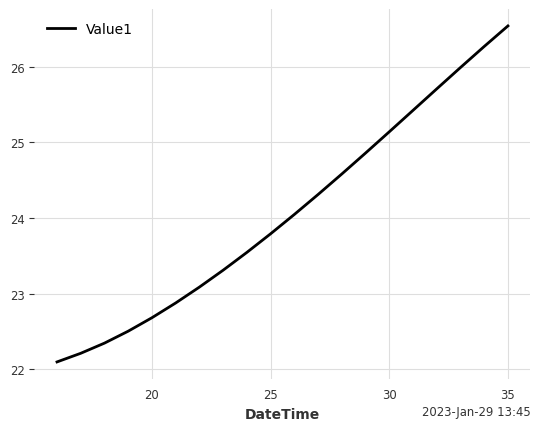

In [128]:
inverted_prediction1.plot()

In [129]:
mae = darts_mae(inverted_prediction1,inverted_prediction2)
mae

2.0556637654096797

In [131]:
# Create TimeSeries objects for Value1 and Value2
series_value1 = TimeSeries.from_dataframe(filtered_df, value_cols='Value1', freq='S')
series_value2 = TimeSeries.from_dataframe(filtered_df, value_cols='Value2', freq='S')

In [132]:
# Fill missing values
filled_series_value1 = fill_missing_values(series_value1, "auto", fill_missing_dates=True)
filled_series_value2 = fill_missing_values(series_value2, "auto", fill_missing_dates=True)

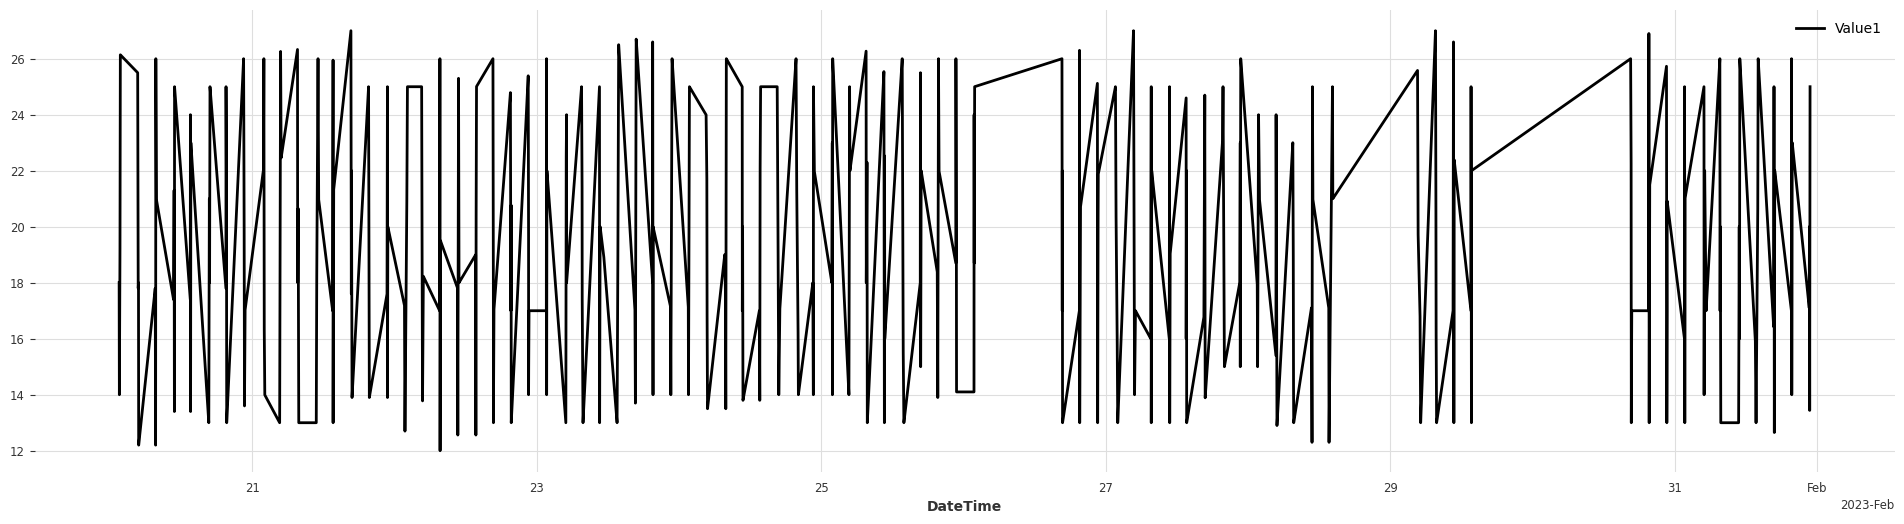

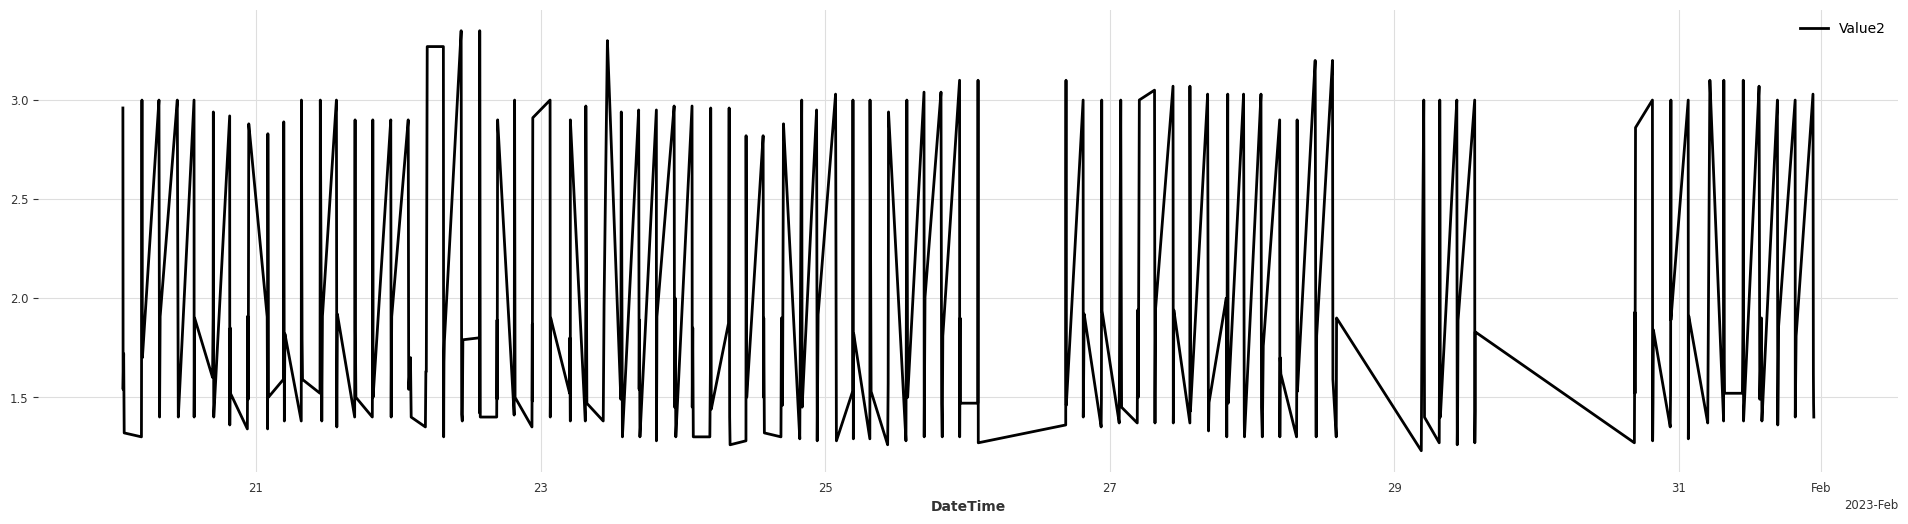

In [133]:
# Set figure size for wider plot
plt.figure(figsize=(24, 6))
# Plot the time series values
filled_series_value1.plot()
plt.show()
plt.figure(figsize=(24, 6))
filled_series_value2.plot()
plt.show()